In [9]:
import os
import sys
import pylab as p
import pylab as pl
import matplotlib as mpl
import pylab as pl
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import r2_score
from matplotlib.offsetbox import AnchoredText
import matplotlib.ticker as ticker
sns.reset_defaults()
import warnings
warnings.filterwarnings('ignore')

# Settings for matplotlib
plt.rcParams["font.family"] = "Arial"
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['pdf.fonttype'] = 42


In [10]:
# Dependency Function Definitions:
def calc_rmsd(x, y):
    if len(x) == 0:
        return 0.0
    chi2 = sum((y - x) ** 2)
    rmsd = np.sqrt(chi2 / len(y))
    return rmsd

def calc_r2(x, y):
    if len(x) == 0:
        return 0.0
    
    return np.corrcoef(x, y)[0,1]**2

def diff(list1, list2):
    c = set(list1).union(set(list2))  # or c = set(list1) | set(list2)
    d = set(list1).intersection(set(list2))  # or d = set(list1) & set(list2)
    common = []
    for element in list1:
        if element in list2:
            common.append(element)
    return list(c - d), common

In [11]:
df_dw_cs = pd.read_csv("data/ES1_measured_dw.csv").loc[:, ["res", "atom", "dw_avg"]].rename(
columns = {'dw_avg': 'dw'})
df_avg_cs = pd.read_csv("data/HIV_TAR_measured_cs.csv").rename(columns = {
    'Resi' : 'res',
    'Atom' : 'atom',
    'Shift': 'w_avg'
}).loc[:, ["res", "atom", "w_avg"]]

df_meas = df_avg_cs.merge(df_dw_cs, on=["res", "atom"], how="outer")
df_meas['w_gs'] = df_meas['w_avg']
df_meas['w_es'] = df_meas['w_avg']
df_meas['rd_flag'] = [False] * df_meas.shape[0]

df_meas.loc[df_meas["dw"].notnull(), "rd_flag"] = True
w_avg = df_meas.loc[df_meas["dw"].notnull(), "w_avg"]
dw = df_meas.loc[df_meas["dw"].notnull(), "dw"]
pES = 0.13
pGS = 0.87

w_es = w_avg + dw * pGS
w_gs = w_es - dw

df_meas.loc[df_meas["dw"].notnull(), "w_es"] = w_es
df_meas.loc[df_meas["dw"].notnull(), "w_gs"] = w_gs
print(df_meas.loc[df_meas.rd_flag==True])

     res atom    w_avg     dw       w_gs       w_es  rd_flag
230   30  C1'   91.879  2.315   91.57805   93.89305     True
247   31  C1'   90.985  2.210   90.69770   92.90770     True
250   31  C4'   84.819 -1.000   84.94900   83.94900     True
253   31   C6  143.380  1.320  143.20840  144.52840     True
293   34  C1'   89.374  2.395   89.06265   91.45765     True
298   34   C8  138.930  2.600  138.59200  141.19200     True
309   35  C1'   90.735  2.795   90.37165   93.16665     True
312   35  C4'   85.084 -2.140   85.36220   83.22220     True


C1' : y = 1.02 x + -9.33
C2' : y = 0.18 x + 60.81
C3' : y = 0.79 x + 12.73
C4' : y = 0.67 x + 26.84
C5' : y = 0.67 x + 19.27
C8 : y = 1.06 x + -2.94
C6 : y = 0.61 x + 56.16
C2 : y = 0.60 x + 61.61
C5 : y = 0.62 x + 38.41
N1/N3 : y = 0.61 x + 52.07


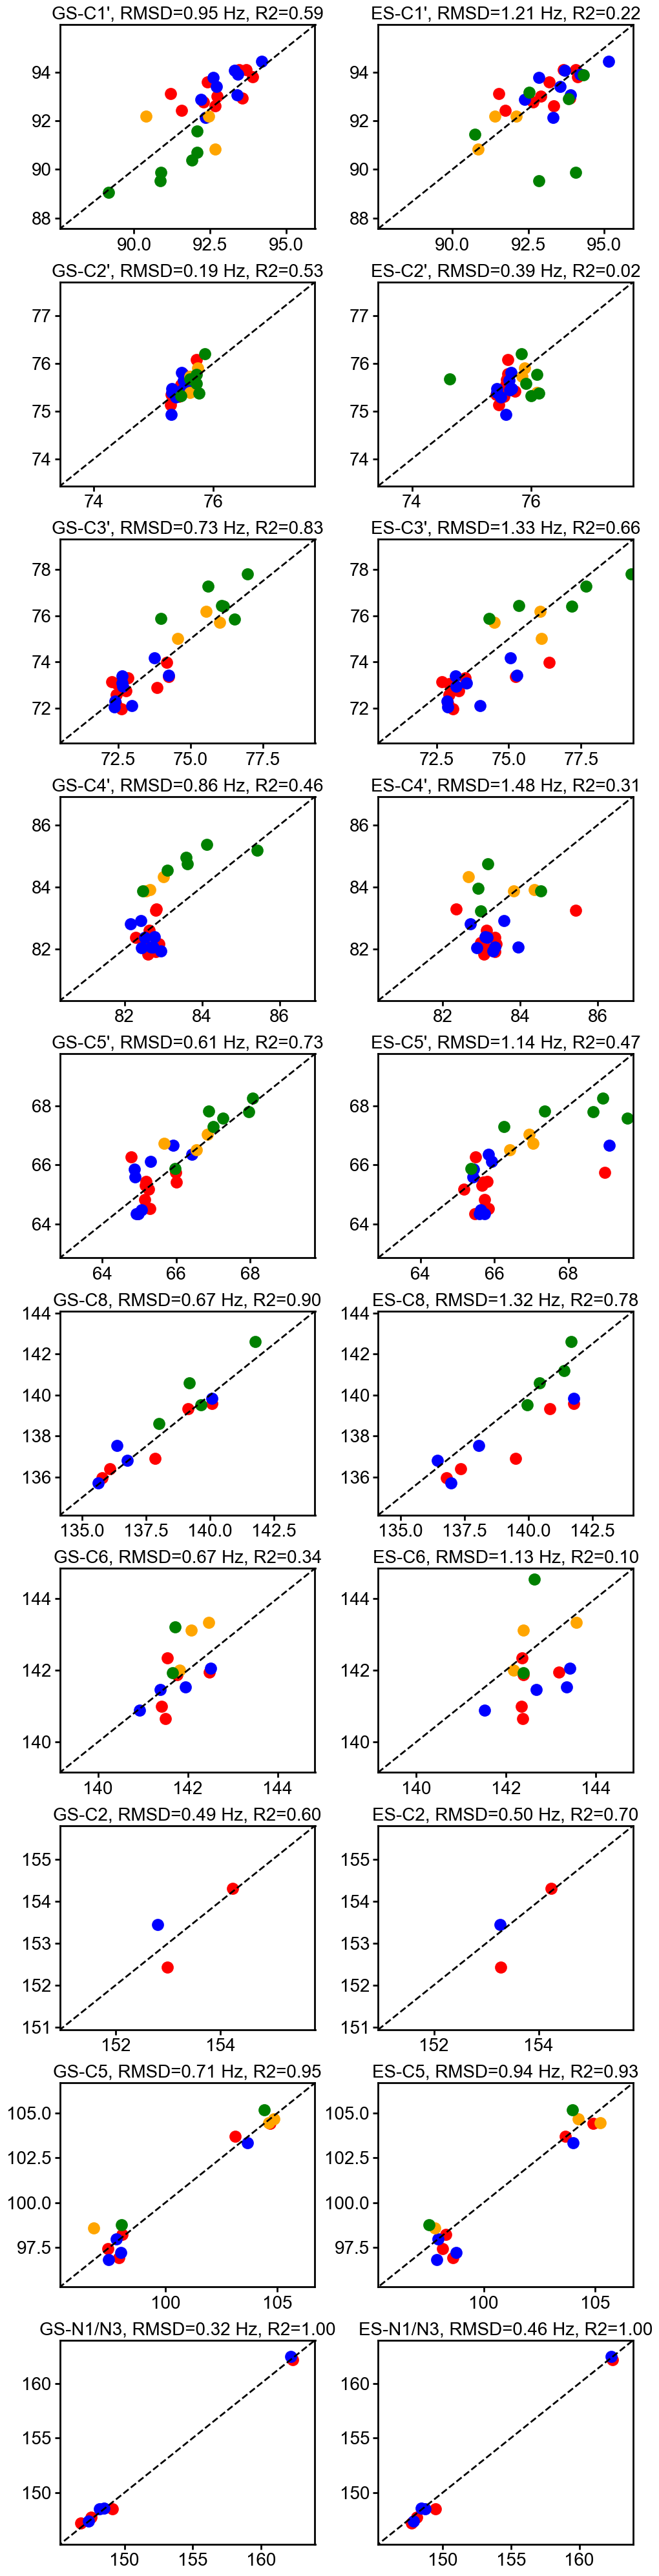

In [12]:
# GS ENS CHEMICAL SHIFTS AGREEMENT:

# Read in CSV data
dfp = pd.read_csv("data/Orca_DFT/outlier_modified_1.csv").drop_duplicates()
#dfm = pd.read_csv("data/HIV_TAR_measured_cs.csv")

# Process & combine predicted & measured data
shift_ens_avg = np.mean(dfp.iloc[:,2:], axis=1)
shift_ens_std = np.std(dfp.iloc[:,2:], axis=1)

shift_gs_avg = np.mean(dfp.iloc[:,2:-4], axis=1)
shift_gs_std = np.std(dfp.iloc[:,2:-4], axis=1)

shift_es_avg = np.mean(dfp.iloc[:,-4:], axis=1)
shift_es_std = np.std(dfp.iloc[:,-4:], axis=1)

dfp["shift_ens_avg"] = shift_ens_avg
dfp["shift_ens_std"] = shift_ens_std

dfp["shift_gs_avg"] = shift_gs_avg
dfp["shift_gs_std"] = shift_gs_std

dfp["shift_es_avg"] = shift_es_avg
dfp["shift_es_std"] = shift_es_std

dfp = dfp.loc[:, ["res", "atom", "shift_ens_avg", "shift_ens_std", 
                  "shift_gs_avg", "shift_gs_std", "shift_es_avg", "shift_es_std"]]

df = df_meas.merge(dfp, on=["res", "atom"], how="inner")

# Define masks for TAR domains:
mask = {}
mask['H1'] = df.res.isin([17, 18, 19, 20 ,21, 22, 40, 41, 42, 43, 44, 45])
mask['H2'] = df.res.isin([26, 27, 28, 29, 36, 37, 38, 39])
mask['B'] = df.res.isin([23, 24, 25])
mask['L'] = df.res.isin([30, 31, 32, 33, 34, 35])

# Define resonances & TAR domains to plot:
domains = ['H1', 'H2', 'B', 'L']
domain_cols = {'H1':'red', 'H2':'blue', 'B':'orange', 'L': 'green'}
resonances = ["C1'", "C2'", "C3'", "C4'", "C5'", "C8", "C6", "C2", "C5", "N1/N3"]
N = len(resonances)

# Prepare figure layout
fig, axs = plt.subplots(N, 2, figsize=(5*2, 4*N))
#df = df.loc[df.rd_flag == True]


# Loop through diff. nuclei:
for idx, resonance in enumerate(resonances):
    if resonance == "N1/N3":
        G_iminos = [18, 21, 26, 28, 36, 43]
        U_iminos = [38, 42]
        filter_N1 = df.res.isin(G_iminos) & (df["atom"] == "N1")
        filter_N3 = df.res.isin(U_iminos) & (df["atom"] == "N3")
        filter_H1 = df.res.isin(G_iminos) & (df["atom"] == "H1")
        filter_H3 = df.res.isin(U_iminos) & (df["atom"] == "H3")
        filter1 = filter_N1 | filter_N3
        filter2 = filter_H1 | filter_H3
        resonance_H = "H1/H3"
        #print(df.loc[filter1])
    else:
        filter1 = (df["atom"] == resonance)
        resonance_H = "H" + resonance[1:]
        filter2 = (df["atom"] == resonance_H)
    
    # Calculate linear correction:
    x = df.loc[filter1]["shift_ens_avg"]
    y = df.loc[filter1]["w_avg"]
    
    m, b = np.polyfit(x, y, 1)   
    print(resonance , ": y = %3.2f x + %3.2f"%(m, b))
        
    
    ### Plot GS chemical shift agreement:
    # Calculate linear correction:
    x = df.loc[filter1]["shift_gs_avg"]
    y = df.loc[filter1]["w_gs"]

    x_H = df.loc[filter1]["shift_es_avg"]
    y_H = df.loc[filter1]["w_es"]
    
    # Set up limits of axes
    lim_up = max(np.max(y), np.max(x*m+b)) + 1.5
    lim_down = min(np.min(y), np.min(x*m+b)) - 1.5
    axs[idx, 0].set_xlim([lim_down, lim_up])
    axs[idx, 0].set_ylim([lim_down, lim_up])
    axs[idx, 1].set_xlim([lim_down, lim_up])
    axs[idx, 1].set_ylim([lim_down, lim_up])
    
    for domain in domains:
        # Plot heavy atom:
        df_f = df.loc[(mask[domain]) & (filter1)]
        if df_f.shape[0] == 0:
            continue
        else:
            col = domain_cols[domain]
            axs[idx, 0].plot( m * df_f.shift_gs_avg + b, df_f.w_gs, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
        # Plot proton associated with it:
        df_f = df.loc[(mask[domain]) & (filter1)]
        if df_f.shape[0] == 0:
            continue
        else:
            col = domain_cols[domain]
            axs[idx, 1].plot( m * df_f.shift_es_avg + b, df_f.w_es, 'o', color=col, 
                             markersize=12, mec=col, markeredgewidth=1.5)
            
    
    axs[idx, 0].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
    axs[idx, 1].plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
    axs[idx, 0].tick_params(width=2,length=6)
    axs[idx, 1].tick_params(width=2,length=6)
    
    x=np.array(x)
    y=np.array(y)
    x_H = np.array(x_H)
    y_H = np.array(y_H)
 
    R2 = calc_r2(m*x+b, y)
    RMSD = calc_rmsd(m*x+b, y)
    axs[idx, 0].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%("GS-" + resonance, RMSD, R2), fontsize=20)
    
    R2_H = calc_r2(m*x_H+b, y_H)
    RMSD_H = calc_rmsd(m*x_H+b, y_H)
    axs[idx, 1].set_title("%s, RMSD=%3.2f Hz, R2=%3.2f"%("ES-" + resonance, RMSD_H, R2_H), fontsize=20)
    
    axs[idx, 0].tick_params(axis='both', which='major', labelsize=20)
    axs[idx, 1].tick_params(axis='both', which='major', labelsize=20)

fig.tight_layout()
#plt.savefig("plots/FARFAR_NMR_ES_vs_GS_DFT_CS_Agreement.pdf")
plt.show()

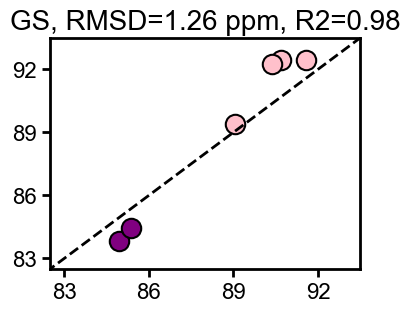

In [13]:
# GS ENS CHEMICAL SHIFTS AGREEMENT:

# Read in CSV data
dfp = pd.read_csv("data/Orca_DFT/outlier_modified_1.csv").drop_duplicates()
#dfm = pd.read_csv("data/HIV_TAR_measured_cs.csv")

# Process & combine predicted & measured data
shift_ens_avg = np.mean(dfp.iloc[:,2:], axis=1)
shift_ens_std = np.std(dfp.iloc[:,2:], axis=1)

shift_gs_avg = np.mean(dfp.iloc[:,2:-4], axis=1)
shift_gs_std = np.std(dfp.iloc[:,2:-4], axis=1)

shift_es_avg = np.mean(dfp.iloc[:,-4:], axis=1)
shift_es_std = np.std(dfp.iloc[:,-4:], axis=1)

dfp["shift_ens_avg"] = shift_ens_avg
dfp["shift_ens_std"] = shift_ens_std

dfp["shift_gs_avg"] = shift_gs_avg
dfp["shift_gs_std"] = shift_gs_std

dfp["shift_es_avg"] = shift_es_avg
dfp["shift_es_std"] = shift_es_std

dfp = dfp.loc[:, ["res", "atom", "shift_ens_avg", "shift_ens_std", 
                  "shift_gs_avg", "shift_gs_std", "shift_es_avg", "shift_es_std"]]

df = df_meas.merge(dfp, on=["res", "atom"], how="inner")
df.loc[df.rd_flag==False, "shift_es_avg"] = df.loc[df.rd_flag==False, "shift_ens_avg"] 
df = df.loc[df.rd_flag == True]


fig, ax = plt.subplots(1, figsize=(4, 3))

def get_correction(atom):
    if atom == "C1'":
        #y = 1.07 x + -13.56
        return (1.07, -13.56)
    
    elif atom == "C4'":
         #y = 0.71 x + 23.7
        return (0.71, 23.7)
    
    elif atom == "C6":
        #y = 0.64 x + 52.48
        return (0.64, 52.48)
    
    elif atom == "C8":
        #y = 1.05 x + -2.00
        return (1.05, -2)

def get_col(atom):
    if atom == "C1'":
        return "pink"
    
    elif atom == "C4'":
         return "purple"
    
    elif atom == "C6":
        return "steelblue"
    
    elif atom == "C8":
        return "seagreen"
    
X = []
Y = []
for idx, row in df.iterrows(): 
    x = row['shift_gs_avg']
    y = row['w_gs']
    atom = row['atom']
    (m,b) = get_correction(atom)
    col = get_col(atom)
    X.append(m*x+b)
    Y.append(y)
    ax.plot(y, m*x + b, marker = 'o', markersize=14, mec="k", markeredgewidth=1.5, color=col)

X = np.array(X)[np.array(X) < 100.0]
Y = np.array(Y)[np.array(Y) < 100.0]
R2 = calc_r2(Y, X)
RMSD = calc_rmsd(X, Y)
ax.set_title("%s, RMSD=%3.2f ppm, R2=%3.2f"%("GS", RMSD, R2), fontsize=20)
ax.plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
ax.set_xlim([82.5, 93.5])
ax.set_ylim([82.5, 93.5])
ax.set_xticks([83, 86, 89, 92])
ax.set_yticks([83, 86, 89, 92])
ax.tick_params(axis='y', which='major', labelsize=16)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(width=2,length=6)
plt.savefig("plots/FINAL_wGS_sugar_correlation.pdf")
plt.show()

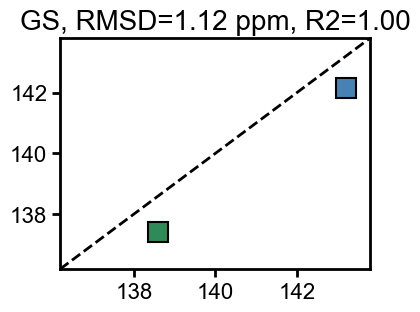

In [14]:
# GS ENS CHEMICAL SHIFTS AGREEMENT:

# Read in CSV data
dfp = pd.read_csv("data/Orca_DFT/outlier_modified_1.csv").drop_duplicates()
#dfm = pd.read_csv("data/HIV_TAR_measured_cs.csv")

# Process & combine predicted & measured data
shift_ens_avg = np.mean(dfp.iloc[:,2:], axis=1)
shift_ens_std = np.std(dfp.iloc[:,2:], axis=1)

shift_gs_avg = np.mean(dfp.iloc[:,2:-4], axis=1)
shift_gs_std = np.std(dfp.iloc[:,2:-4], axis=1)

shift_es_avg = np.mean(dfp.iloc[:,-4:], axis=1)
shift_es_std = np.std(dfp.iloc[:,-4:], axis=1)

dfp["shift_ens_avg"] = shift_ens_avg
dfp["shift_ens_std"] = shift_ens_std

dfp["shift_gs_avg"] = shift_gs_avg
dfp["shift_gs_std"] = shift_gs_std

dfp["shift_es_avg"] = shift_es_avg
dfp["shift_es_std"] = shift_es_std

dfp = dfp.loc[:, ["res", "atom", "shift_ens_avg", "shift_ens_std", 
                  "shift_gs_avg", "shift_gs_std", "shift_es_avg", "shift_es_std"]]

df = df_meas.merge(dfp, on=["res", "atom"], how="inner")
df.loc[df.rd_flag==False, "shift_es_avg"] = df.loc[df.rd_flag==False, "shift_ens_avg"] 
df = df.loc[df.rd_flag == True]


fig, ax = plt.subplots(1, figsize=(4, 3))

def get_correction(atom):
    if atom == "C1'":
        #y = 1.07 x + -13.56
        return (1.07, -13.56)
    
    elif atom == "C4'":
         #y = 0.71 x + 23.7
        return (0.71, 23.7)
    
    elif atom == "C6":
        #y = 0.64 x + 52.48
        return (0.64, 52.48)
    
    elif atom == "C8":
        #y = 1.05 x + -2.00
        return (1.05, -2)

def get_col(atom):
    if atom == "C1'":
        return "pink"
    
    elif atom == "C4'":
         return "purple"
    
    elif atom == "C6":
        return "steelblue"
    
    elif atom == "C8":
        return "seagreen"
    
X = []
Y = []
for idx, row in df.iterrows(): 
    x = row['shift_gs_avg']
    y = row['w_gs']
    atom = row['atom']
    (m,b) = get_correction(atom)
    col = get_col(atom)
    X.append(m*x+b)
    Y.append(y)
    ax.plot(y, m*x + b, marker = 's', markersize=14, mec="k", markeredgewidth=1.5, color=col)

X = np.array(X)[np.array(X) > 100.0]
Y = np.array(Y)[np.array(Y) > 100.0]
R2 = calc_r2(Y, X)
RMSD = calc_rmsd(X, Y)
ax.set_title("%s, RMSD=%3.2f ppm, R2=%3.2f"%("GS", RMSD, R2), fontsize=20)
ax.plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
ax.set_xlim([136.2, 143.8])
ax.set_ylim([136.2, 143.8])
#ax.set_xticks([83, 86, 89, 92])
#ax.set_yticks([83, 86, 89, 92])
ax.tick_params(axis='y', which='major', labelsize=16)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(width=2,length=6)
plt.savefig("plots/FINAL_wGS_aromatic_correlation.pdf")
plt.show()

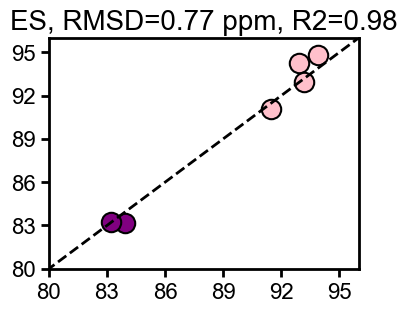

In [15]:
# GS ENS CHEMICAL SHIFTS AGREEMENT:

# Read in CSV data
dfp = pd.read_csv("data/Orca_DFT/outlier_modified_1.csv").drop_duplicates()
#dfm = pd.read_csv("data/HIV_TAR_measured_cs.csv")

# Process & combine predicted & measured data
shift_ens_avg = np.mean(dfp.iloc[:,2:], axis=1)
shift_ens_std = np.std(dfp.iloc[:,2:], axis=1)

shift_gs_avg = np.mean(dfp.iloc[:,2:-4], axis=1)
shift_gs_std = np.std(dfp.iloc[:,2:-4], axis=1)

shift_es_avg = np.mean(dfp.iloc[:,-4:], axis=1)
shift_es_std = np.std(dfp.iloc[:,-4:], axis=1)

dfp["shift_ens_avg"] = shift_ens_avg
dfp["shift_ens_std"] = shift_ens_std

dfp["shift_gs_avg"] = shift_gs_avg
dfp["shift_gs_std"] = shift_gs_std

dfp["shift_es_avg"] = shift_es_avg
dfp["shift_es_std"] = shift_es_std

dfp = dfp.loc[:, ["res", "atom", "shift_ens_avg", "shift_ens_std", 
                  "shift_gs_avg", "shift_gs_std", "shift_es_avg", "shift_es_std"]]

df = df_meas.merge(dfp, on=["res", "atom"], how="inner")
df.loc[df.rd_flag==False, "shift_es_avg"] = df.loc[df.rd_flag==False, "shift_ens_avg"] 
df = df.loc[df.rd_flag == True]


fig, ax = plt.subplots(1, figsize=(4, 3))

def get_correction(atom):
    if atom == "C1'":
        #y = 1.07 x + -13.56
        return (1.07, -13.56)
    
    elif atom == "C4'":
         #y = 0.71 x + 23.7
        return (0.71, 23.7)
    
    elif atom == "C6":
        #y = 0.64 x + 52.48
        return (0.64, 52.48)
    
    elif atom == "C8":
        #y = 1.05 x + -2.00
        return (1.05, -2)

def get_col(atom):
    if atom == "C1'":
        return "pink"
    
    elif atom == "C4'":
         return "purple"
    
    elif atom == "C6":
        return "steelblue"
    
    elif atom == "C8":
        return "seagreen"
    
X = []
Y = []
for idx, row in df.iterrows(): 
    x = row['shift_es_avg']
    y = row['w_es']
    atom = row['atom']
    (m,b) = get_correction(atom)
    col = get_col(atom)
    X.append(m*x+b)
    Y.append(y)
    ax.plot(y, m*x + b, marker = 'o', markersize=14, mec="k", markeredgewidth=1.5, color=col)

X = np.array(X)[np.array(X) < 100.0]
Y = np.array(Y)[np.array(Y) < 100.0]
R2 = calc_r2(Y, X)
RMSD = calc_rmsd(X, Y)
ax.set_title("%s, RMSD=%3.2f ppm, R2=%3.2f"%("ES", RMSD, R2), fontsize=20)
ax.plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
ax.set_xlim([80, 96])
ax.set_ylim([80, 96])
ax.set_xticks([80, 83, 86, 89, 92, 95])
ax.set_yticks([80, 83, 86, 89, 92, 95])
ax.tick_params(axis='y', which='major', labelsize=16)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(width=2,length=6)
plt.savefig("plots/FINAL_wES_sugar_correlation.pdf")
plt.show()

[143.11984   140.7719125]


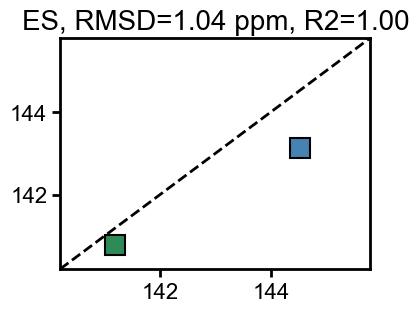

In [16]:
# GS ENS CHEMICAL SHIFTS AGREEMENT:

# Read in CSV data
dfp = pd.read_csv("data/Orca_DFT/outlier_modified_1.csv").drop_duplicates()
#dfm = pd.read_csv("data/HIV_TAR_measured_cs.csv")

# Process & combine predicted & measured data
shift_ens_avg = np.mean(dfp.iloc[:,2:], axis=1)
shift_ens_std = np.std(dfp.iloc[:,2:], axis=1)

shift_gs_avg = np.mean(dfp.iloc[:,2:-4], axis=1)
shift_gs_std = np.std(dfp.iloc[:,2:-4], axis=1)

shift_es_avg = np.mean(dfp.iloc[:,-4:], axis=1)
shift_es_std = np.std(dfp.iloc[:,-4:], axis=1)

dfp["shift_ens_avg"] = shift_ens_avg
dfp["shift_ens_std"] = shift_ens_std

dfp["shift_gs_avg"] = shift_gs_avg
dfp["shift_gs_std"] = shift_gs_std

dfp["shift_es_avg"] = shift_es_avg
dfp["shift_es_std"] = shift_es_std

dfp = dfp.loc[:, ["res", "atom", "shift_ens_avg", "shift_ens_std", 
                  "shift_gs_avg", "shift_gs_std", "shift_es_avg", "shift_es_std"]]

df = df_meas.merge(dfp, on=["res", "atom"], how="inner")
df.loc[df.rd_flag==False, "shift_es_avg"] = df.loc[df.rd_flag==False, "shift_ens_avg"] 
df = df.loc[df.rd_flag == True]


fig, ax = plt.subplots(1, figsize=(4, 3))

def get_correction(atom):
    if atom == "C1'":
        #y = 1.07 x + -13.56
        return (1.07, -13.56)
    
    elif atom == "C4'":
         #y = 0.71 x + 23.7
        return (0.71, 23.7)
    
    elif atom == "C6":
        #y = 0.64 x + 52.48
        return (0.64, 52.48)
    
    elif atom == "C8":
        #y = 1.05 x + -2.00
        return (1.05, -2)

def get_col(atom):
    if atom == "C1'":
        return "pink"
    
    elif atom == "C4'":
         return "purple"
    
    elif atom == "C6":
        return "steelblue"
    
    elif atom == "C8":
        return "seagreen"
    
X = []
Y = []
for idx, row in df.iterrows(): 
    #print(x)
    #print(y)
    x = row['shift_es_avg']
    y = row['w_es']
    atom = row['atom']
    (m,b) = get_correction(atom)
    col = get_col(atom)
    X.append(m*x+b)
    Y.append(y)
    ax.plot(y, m*x + b, marker = 's', markersize=14, mec="k", markeredgewidth=1.5, color=col)

X = np.array(X)[np.array(X) > 100.0]
Y = np.array(Y)[np.array(Y) > 100.0]
print(X)
R2 = calc_r2(Y, X)
RMSD = calc_rmsd(X, Y)
ax.set_title("%s, RMSD=%3.2f ppm, R2=%3.2f"%("ES", RMSD, R2), fontsize=20)
ax.plot([-1000, 1000], [-1000, 1000], color='k', ls='--', lw=2)
ax.set_xlim([140.2, 145.8])
ax.set_ylim([140.2, 145.8])
#ax.set_xticks([83, 86, 89, 92])
#ax.set_yticks([83, 86, 89, 92])
ax.tick_params(axis='y', which='major', labelsize=16)
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(width=2,length=6)
plt.savefig("plots/FINAL_wES_aromatic_correlation.pdf")
plt.show()